# Super resolution
This notebook describes implementation of super resolution algorythm based on Farsiu's paper:

http://ai2-s2-pdfs.s3.amazonaws.com/6199/7bb7d5a041353582599caf52fd5014cf60cb.pdf

Good starting point could be this implementation, which describes both methods introduced in paper:

http://www1.idc.ac.il/toky/videoProc-07/projects/SuperRes/srproject.html

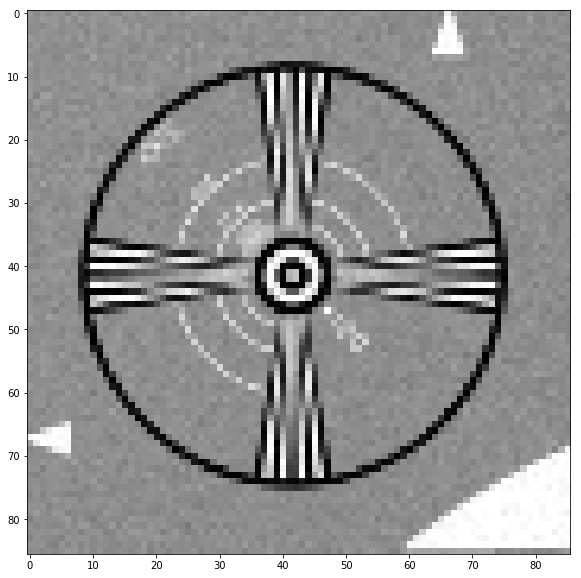

In [301]:
%matplotlib inline

import glob
import random

import matplotlib.pyplot as plt
from ipykernel.pylab.backend_inline import flush_figures

from skimage import img_as_uint, img_as_ubyte, data
from skimage.io import imread, imsave
from skimage.transform import downscale_local_mean, ProjectiveTransform, warp, SimilarityTransform, rotate, rescale
from skimage.util import random_noise, crop
from skimage.feature import corner_fast, peak_local_max, corner_harris, corner_peaks
from skimage.restoration import richardson_lucy, richardson_lucy

from scipy.ndimage.filters import convolve, correlate
from scipy.io import savemat, loadmat

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets

import numpy as np

import cv2

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'

images = []
original_images = []
lr_images = []
lr_deviations = []
hr_est = None

"""
for filename in glob.glob('./static_image_series/*.tiff'):
    image = downscale_local_mean(imread(filename, as_grey=True), (20, 20))
    #image = downscale_local_mean(data.coins(), (4, 4))
    images.append(image)
"""""""""
# images = loadmat("C:\Users\Petr\Downloads\SRes\eia_lr.mat")
original_images = np.moveaxis(loadmat('C:\\Users\Petr\Downloads\SRes\eia_lr.mat')['eia_lr'], (0, 1, 2), (2, 1, 0))

# corp images
original_images
for idx, image in enumerate(original_images):
    images.append(crop(image, 2, copy=False, order='K'))
plt.figure(figsize=(10,10))
plt.imshow(images[0])

# Preproces low res images
We need to preprocess low res images in the way so they are randomly moved in the x and y axis.

In [159]:
max_deviation_slider = widgets.FloatSlider(min=0.5, max=10, step=1, value=0.5, continuous_update=False)
    
@interact(max_deviation=max_deviation_slider)
def x_noise(max_deviation):
    global lr_images
    global lr_deviations
    global averaged_flows
    averaged_flows = np.empty((0,2))
    lr_images = []
    lr_deviations = []

    for i in range(1, 20):
        #deviation = np.random.uniform(-max_deviation, max_deviation, 2)
        #deviation = (int(idx / 4) / 4, (idx % 4) / 4)
        averaged_flows = np.append(averaged_flows, [deviation] ,axis = 0) 

        tform = SimilarityTransform(translation=deviation)
        lr_images.append((warp(images[0], tform, mode='edge')))
        lr_deviations.append(deviation)
        
    print(lr_deviations)
    plt.figure(figsize=(10, 10))
    print('Averaged dataset:')
    plt.imshow(np.mean(lr_images, axis=0))
    savemat('out.mat', mdict={'images': np.moveaxis(lr_images, (0, 1, 2), (2, 1, 0))})
    

A Jupyter Widget

## Optical flow image registration
At first we need to process image registration to find out movement vectors between images. 
The registration is processed between a base image (first in low res images array) and other low res images.

Here are some examples of optical flow registration implementation using numpy and skimage: 
https://gist.github.com/jhaberstro

## Robust super resolution implementation
The algorithm shoul e implemented acording to following flowchart:

![sr fch](resources/sr_fch.png)

It is implementation of this eq:

![sr eq](resources/sr_eq.png)

Down and up sampling is done in folowing way:

![ds us](resources/ds_us.png)

In [326]:
averaged_flows = np.empty((0,2))

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 6,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
# Create some random colors
peaks = cv2.goodFeaturesToTrack(images[0].astype(np.uint8), mask = None, **feature_params)
#p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

for image in images:
    nextPts, status, err = cv2.calcOpticalFlowPyrLK(images[0].astype(np.uint8), image.astype(np.uint8), peaks, None, **lk_params)
    diff = np.squeeze(nextPts[status==1] - peaks[status==1])
    averaged_flow = np.average(diff, axis=0)
    averaged_flows = np.append(averaged_flows, [averaged_flow.astype(np.int8)],axis = 0) 
    
print(averaged_flows)

[[ 0.  0.]
 [ 2.  0.]
 [ 3. -1.]
 [ 4.  2.]
 [ 3.  0.]
 [ 3.  0.]
 [ 2. -1.]
 [ 4.  0.]
 [ 4.  3.]
 [ 4.  3.]
 [ 2.  0.]
 [ 2. -1.]
 [ 4.  4.]
 [ 1.  0.]
 [ 2.  0.]
 [ 2. -1.]]


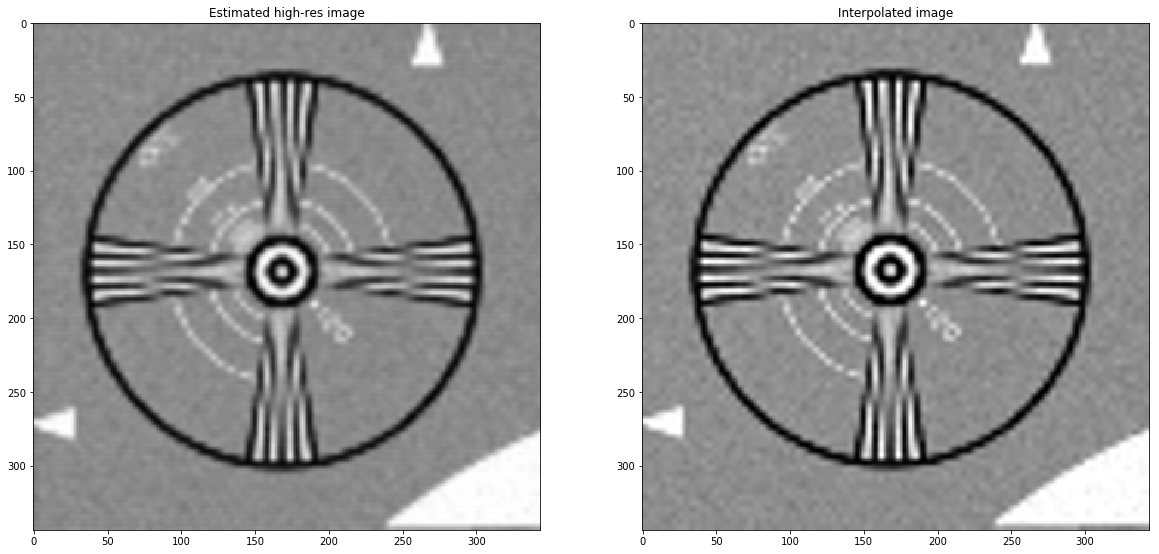

In [331]:
def gradient_back_project(hr_est, lr_imgs, flow, res_fac):
    result = np.zeros(np.array(hr_est).shape)
    for idx, lr_img in enumerate(lr_imgs):
        # shift decimated high res image estimation
        tform = SimilarityTransform(translation=(flow[idx][0], flow[idx][1]))
        hr_shifted = warp(hr_est, tform, mode='edge', preserve_range=True, order=0)
        
        # convole with gaussian PSF
        kernel = gaussian_kernel()
        hr_smoothed = convolve(hr_shifted, kernel)
        
        # downscale high res estimation by res factor
        hr_dowscaled = hr_smoothed[0::res_fac, 0::res_fac]

        # compute sign between hr_est_decimated and low res image
        sign = np.sign(hr_dowscaled - lr_img)

        # upscale sign 
        sign_upscaled = np.zeros(np.array(hr_est).shape)
        sign_upscaled[0::res_fac, 0::res_fac] = sign[:,:]
        
        # convolution by transposed gaussian kernel
        sign_conv = convolve(sign_upscaled, np.transpose(kernel))
        
        # shift back
        tform = SimilarityTransform(translation=(-flow[idx][0], -flow[idx][1]))
        sign_shifted = warp(sign_conv, tform, mode='edge', preserve_range=True, order=0)
        result = result + sign_shifted
    return result
    
def gradient_regulization(hr_est, P, alpha):
    result = np.zeros(np.array(hr_est).shape)
    for l in range(-P, P):
        for m in range(0, P):
            if m + l >= 0:
                # shift high res by l and m
                tform = SimilarityTransform(translation=(l, m))
                hr_est_shifted = warp(hr_est, tform, mode='edge', preserve_range=True, order=0)
                # sign of substraction
                sign = np.sign(hr_est - hr_est_shifted)
                # shift sign back by l and m
                tform = SimilarityTransform(translation=(-l, -m))
                sign_shifted = warp(hr_est, tform, mode='edge', preserve_range=True, order=0)
                result = result +  np.multiply(sign - sign_shifted, alpha**(np.absolute(l) + np.absolute(m)))
    return result
    
def gaussian_kernel(l=5, sig=1):
    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sig**2))
    return kernel / np.sum(kernel)

# estimate HR image using 
hr_estimation = rescale(images[0], 4, mode='edge', order=3)
hr = hr_estimation
beta = 1
lamb = 0.04
res_factor = 4

for i in range(0, 20):
    gbp = gradient_back_project(hr_estimation, images, averaged_flows, res_factor)
    greg = gradient_regulization(hr_estimation, 2, 0.7)
    hr_estimation = hr_estimation - np.multiply(np.multiply(greg, lamb) + gbp, beta)

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.title('Estimated high-res image')
plt.imshow(hr_estimation)
plt.subplot(122)
plt.title('Interpolated image')
plt.imshow(hr)